# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import cftime
import pandas as pd
import matplotlib
from pprint import pprint

from urbanmask.urban_areas import (
    UrbanVicinity
)
from urbanmask.UHI_plot_functions import (
    plot_climatology,
    plot_annual_cycle
)
from urbanmask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
    RCM_DICT,
    load_ucdb_city
)
from urbanmask.UHI_analysis import UrbanIsland

from urbanmask.GHCNd_stations import (
    load_ghcnd_stations,
    get_ghcnd_df,
    get_valid_timeseries,
    available_vars,
    inside_city
)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly -explanatory. _(Explain here those with are not)_

## CORDEX-CORE (0.22) REMO

In [3]:
city = 'Paris'
lon_city = 2.35
lat_city = 48.85

domain = 'EUR-22'
model = 'REMO'
scenario = "evaluation"

urban_var = 'sftimf'

urban_th = 10
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 0
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [4]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [5]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [6]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
root_esgf = "/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/"

In [7]:
file_sfturf = glob.glob(
        f"{root_nextcloud}{model}/{urban_var}/{urban_var}_{domain}*.nc" 
)

file_orog = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
)
file_sftlf = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/sftlf/*/sftlf_*.nc" 
)

In [8]:
ds_sfturf = xr.open_dataset(file_sfturf[0])
ds_orog = xr.open_dataset(file_orog[0])
ds_sftlf = xr.open_dataset(file_sftlf[0])

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

In [9]:
#https://github.com/euro-cordex/evaltools/blob/CMIP5/evaltools/download_cmip5-cordex.py

Add parameters to the function

In [10]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [11]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sfturf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [12]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [13]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

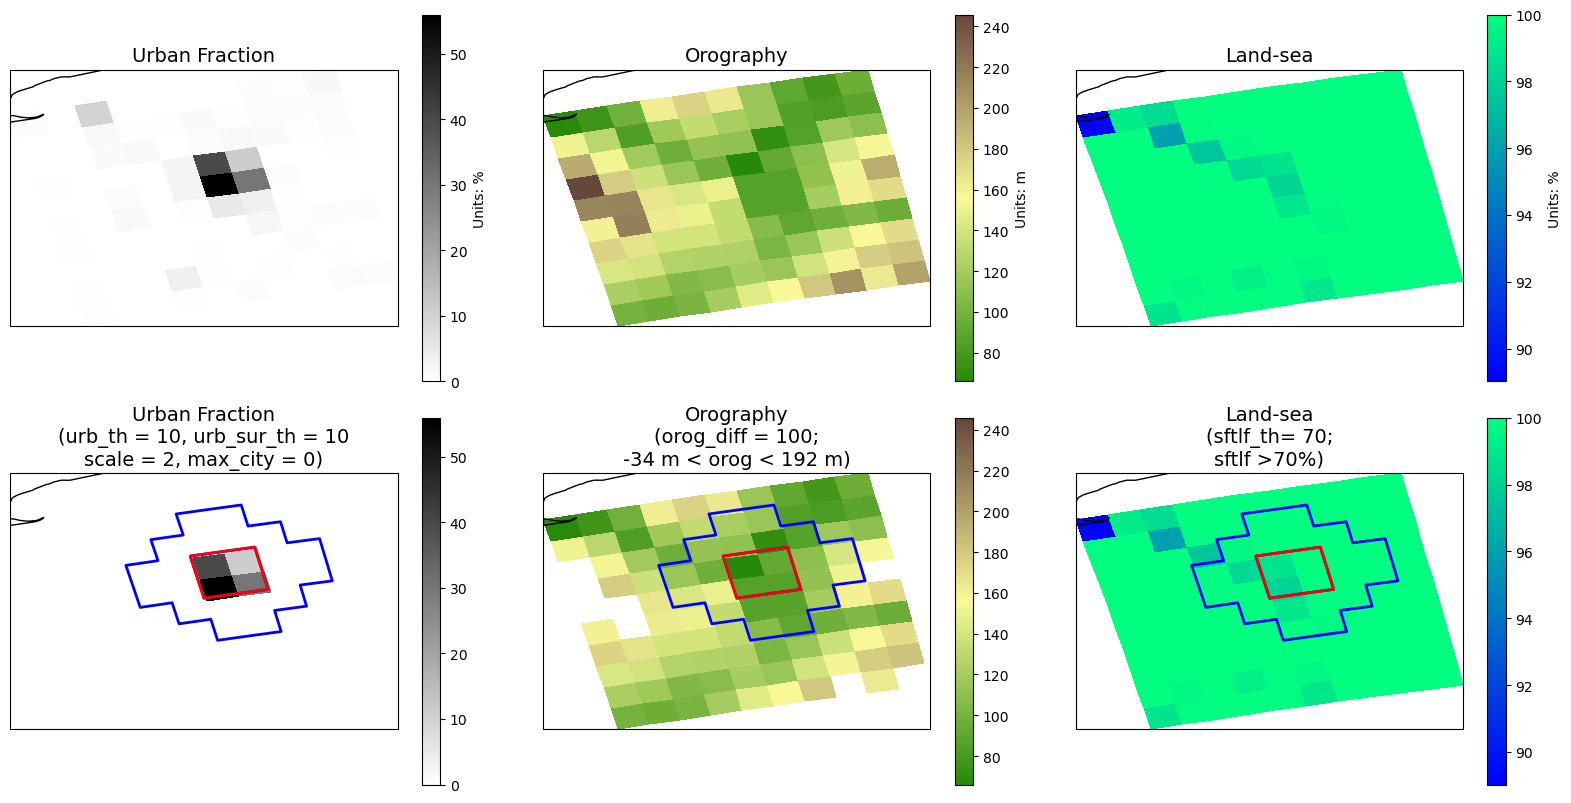

In [14]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [15]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate Urban Heat Island (UHI)

### Load climate variable

In [16]:
variable = 'tasmin'

In [17]:
files_pattern = f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/*/{scenario}/*/{RCM_DICT[domain][model].split('_')[1]}/*/day/{variable}/*/{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time')

In [18]:
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution)

### Load city shapefile

In [20]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
ucdb_city = load_ucdb_city(root_nextcloud, city)

## Stations

In [21]:
output_file = "PARIS_surface_weather_data/Data_MF_1980-2017.csv"
radious = 0.5

stan_data = pd.read_csv(output_file)
stan_data['code'] = stan_data['code'].astype(str)

In [22]:
stan_data = stan_data.loc[stan_data['dist'] < radious]

### Select coincident period between Model and Observations

In [23]:
valid_obs, time_series_obs, ds_RCM_period = get_valid_timeseries(
    city, stan_data, ds_RCM, variable, idate='1979-01-01', fdate='2014-12-31', divide= 1
)

/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

Paris -- PARIS-MONTSOURIS - TMIN has 97.2% valid records in 1979-01-01 to 2014-12-31
Paris -- MELUN - TMIN has 97.2% valid records in 1979-01-01 to 2014-12-31
Paris -- TOUSSUS-LE-NOBLE - TMIN has 91.7% valid records in 1979-01-01 to 2014-12-31
Paris -- TRAPPES - TMIN has 97.2% valid records in 1979-01-01 to 2014-12-31


/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

Paris -- VILLACOUBLAY - TMIN has 97.2% valid records in 1979-01-01 to 2014-12-31
Paris -- ORLY - TMIN has 97.2% valid records in 1979-01-01 to 2014-12-31
Paris -- BRETIGNY-SAPC - TMIN has 97.1% valid records in 1979-01-01 to 2014-12-31
Paris -- ROISSY - TMIN has 97.2% valid records in 1979-01-01 to 2014-12-31


/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')


#### Calculate observations both inside and outside the city

In [24]:
valid_obs = inside_city(valid_obs, ucdb_city)

There are 4 series inside the city and 4 outside


/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_obs['inside_city'] = np.nan
/home/yaizaquintana/Desktop/GIT/urbanmask/GHCNd_stations.py:152: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  valid_obs.loc[valid_obs['code'].str.contains(obs.code), 'inside_city'] = is_inside.values[0]


### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

In [25]:
UHI = UrbanIsland(
    ds = ds_RCM_period[variable],
    urban_vicinity = urmask,
    anomaly = 'abs',
    obs_attributes = valid_obs,
    obs_timeseries = time_series_obs
)

## Plot the data

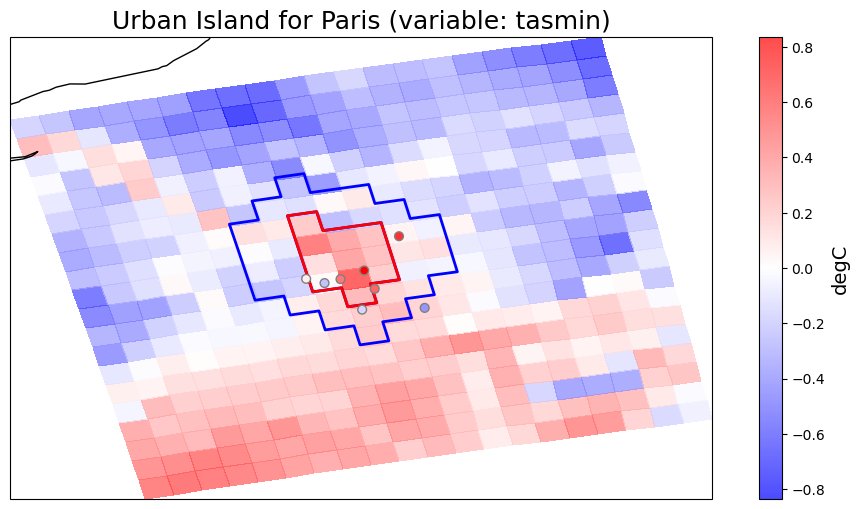

In [50]:
fig = UHI.plot_UI_map(
    city_name = city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

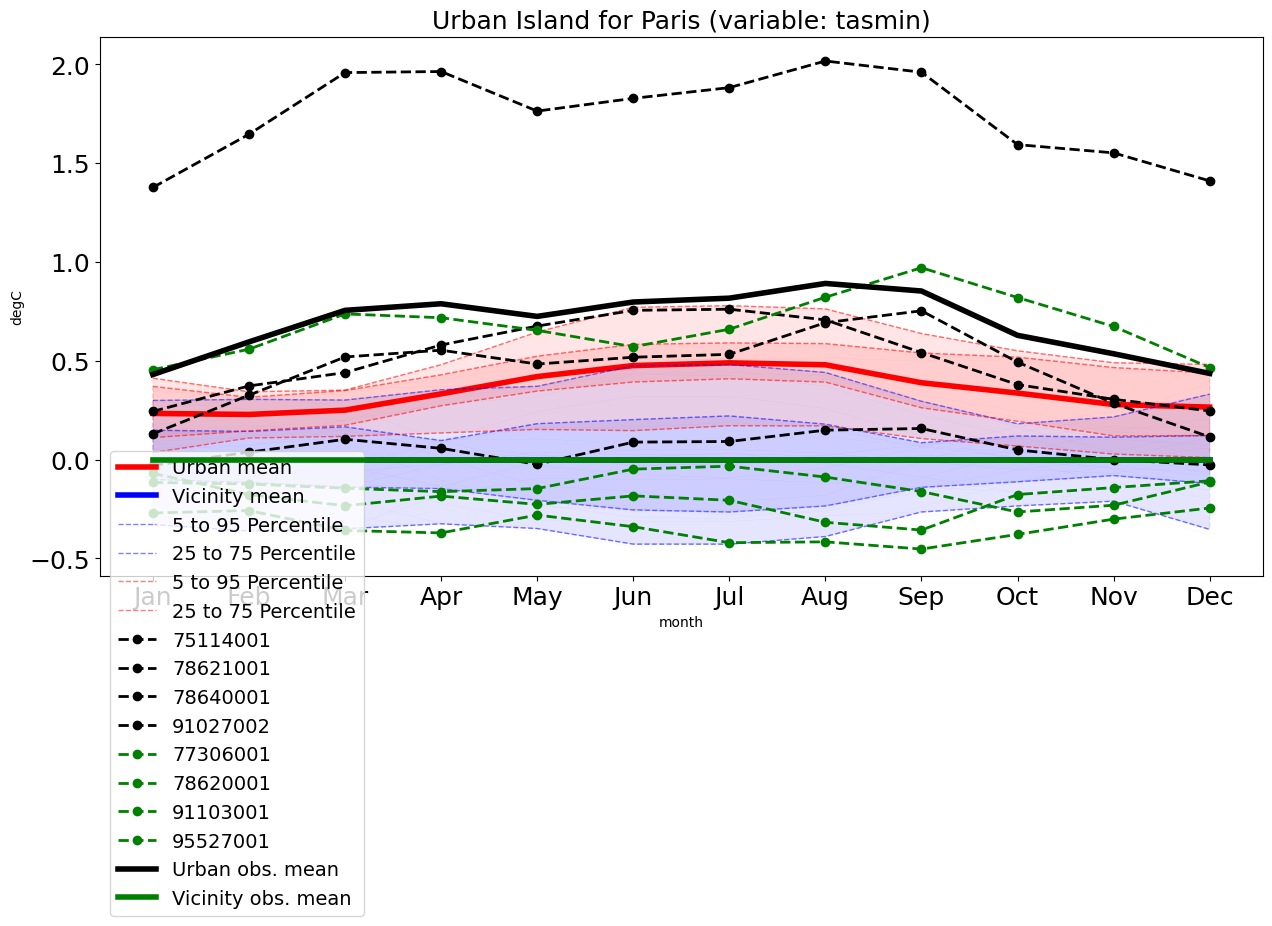

In [29]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5,25],
    gridcell_series = True, 
    city_name = city)


## CORDEX-EUR-11 (0.11) REMO


In [37]:
city = 'Paris'
lon_city = 2.35
lat_city = 48.85

domain = 'EUR-11'
model = 'REMO'
scenario = "evaluation"

urban_var = 'sftimf'

urban_th = 10
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 2
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [38]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [39]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [40]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
root_esgf = "/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/"

In [41]:
file_sfturf = glob.glob(
        f"{root_nextcloud}{model}/{urban_var}/{urban_var}_{domain}*.nc" 
)

file_orog = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
)
file_sftlf = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/sftlf/*/sftlf_*.nc" 
)

In [42]:
ds_sfturf = xr.open_dataset(file_sfturf[0])
ds_orog = xr.open_dataset(file_orog[0])
ds_sftlf = xr.open_dataset(file_sftlf[0])

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

Add parameters to the function

In [36]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [10]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sfturf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [11]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [13]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

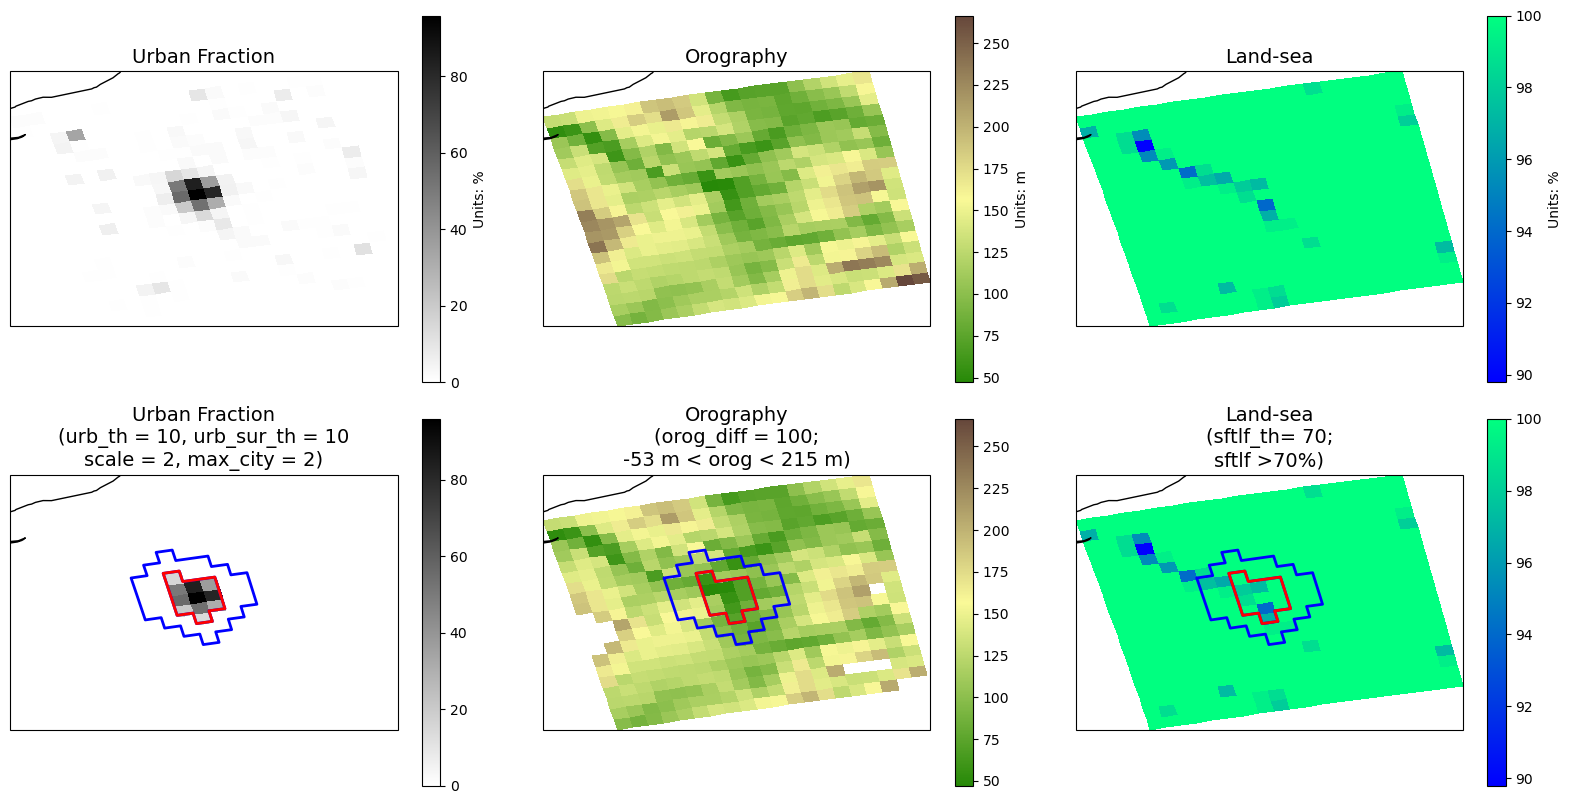

In [14]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [15]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate Urban Heat Island (UHI)

### Load climate variable

In [23]:
variable = 'tasmin'

In [ ]:
files_pattern = f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/*/{scenario}/*/{RCM_DICT[domain][model].split('_')[1]}/*/day/{variable}/*/{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time')

In [ ]:
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution)

### Compute the climatology of anomalies with respect to rural vicinity mean

In [19]:
UHI = UrbanIsland(
    ds = ds_RCM[variable],
    urban_vicinity = urmask,
    anomaly = 'abs'
)

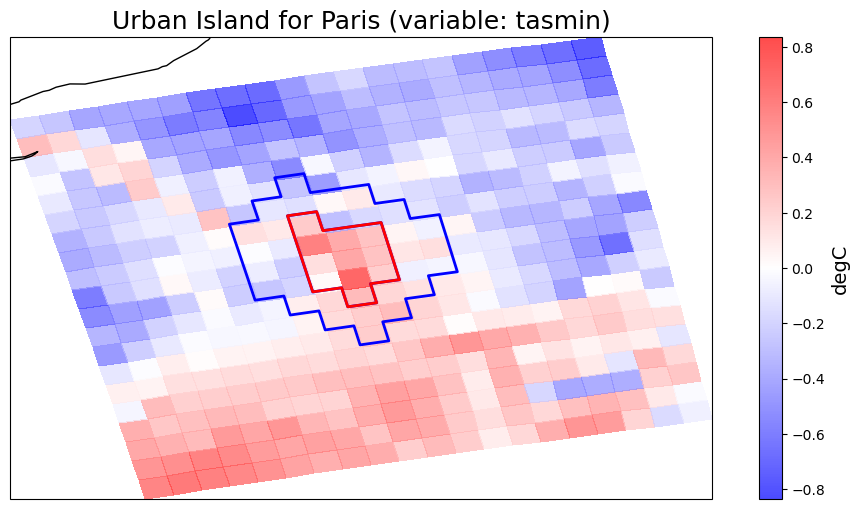

In [19]:
fig = UHI.plot_UI_map(
    city_name = city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

In [ ]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5,25],
    gridcell_series = True, 
    city_name = city)

## CORDEX-EUR-03 (0.03) REMO

In [49]:
abbr_city = 'Paris'

variable = 'tas'
urban_var = 'sftimf'
observations = True
domain = 'EUR-03'
model = 'REMO' # REMO/RegCM
scenario = 'evaluation'
root_esgf = '/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/'
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
base_output_dir = 'results_paper'

lon_city = 2.35
lat_city = 48.85

urban_th = 60
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 5 # remove small urban centers (numbero of cells)
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [50]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [51]:
domain_resolution = 3
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [54]:
root = '/lustre/gmeteo/ASNA/projects/fpsurbrcc/02_stage0_run/data/dkrz/PARIS-3/GERICS/ERA5/evaluation/r1i1p1f1/REMO2020-TEB/v1-fpsurbrcc-s0r1/'

In [59]:
ds_sftuf = xr.open_dataset(root + "fx/sfturf/v20241211/sfturf_PARIS-3_ERA5_evaluation_r1i1p1f1_GERICS_REMO2020-TEB_v1-fpsurbrcc-s0r1_fx.nc")
ds_orog = xr.open_dataset(root + "fx/orog/v20241211/orog_PARIS-3_ERA5_evaluation_r1i1p1f1_GERICS_REMO2020-TEB_v1-fpsurbrcc-s0r1_fx.nc")
ds_sftlf = xr.open_dataset(root + "fx/sftlf/v20241211/sftlf_PARIS-3_ERA5_evaluation_r1i1p1f1_GERICS_REMO2020-TEB_v1-fpsurbrcc-s0r1_fx.nc")

In [60]:
ds_sftuf['sftimf']=ds_sftuf['sfturf']

Add parameters to the function

In [61]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [62]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sfturf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [63]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

ValueError: Cannot apply_along_axis when any iteration dimensions are 0

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [ ]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

In [ ]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [15]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate Urban Heat Island (UHI)

### Load climate variable

In [67]:
variable = 'tas'

In [69]:
files_pattern = f"{root}1hr/{variable}/*/*{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time')

In [ ]:
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution)

### Compute the climatology of anomalies with respect to rural vicinity mean

In [19]:
UHI = UrbanIsland(
    ds = ds_RCM[variable],
    urban_vicinity = urmask,
    anomaly = 'abs'
)

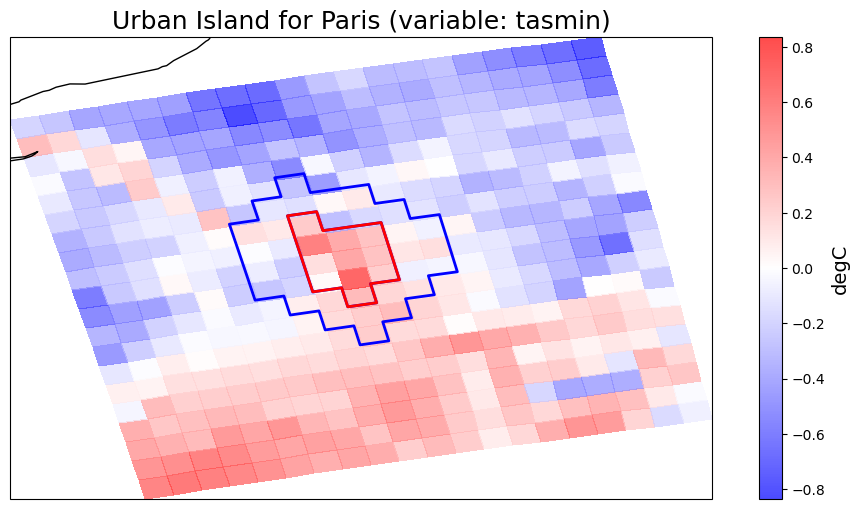

In [19]:
fig = UHI.plot_UI_map(
    city_name = city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

In [ ]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5,25],
    gridcell_series = True, 
    city_name = city)